In [1]:
from pathlib import Path
import progressbar as pb
import warnings # supress warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import Normalizer, StandardScaler, normalize
from sklearn import metrics
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

In [2]:
%env KAGGLE_USERNAME=joaopaguiar
%env KAGGLE_KEY=7ef11663a308234bd531dd972d69ed41

!kaggle datasets download -d arjunbhasin2013/ccdata --unzip -p /content/ccdata
!ls /content/ccdata

env: KAGGLE_USERNAME=joaopaguiar
env: KAGGLE_KEY=7ef11663a308234bd531dd972d69ed41
  0% 0.00/340k [00:00<?, ?B/s]
100% 340k/340k [00:00<00:00, 11.2MB/s]
'CC GENERAL.csv'


In [3]:
DATA_PATH = Path("/content/ccdata")

df = pd.read_csv(DATA_PATH / "CC GENERAL.csv")

In [4]:
df.drop(columns='CUST_ID',inplace=True)

In [5]:
df.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [6]:
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].min(), inplace=True)
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].min(), inplace=True)

In [7]:
df1=df[df['BALANCE'] < df['BALANCE'].quantile(.95)]
df1=df1[df1['PURCHASES'] < df['PURCHASES'].quantile(.95)]
df1=df1[df1['ONEOFF_PURCHASES'] < df['ONEOFF_PURCHASES'].quantile(.95)]
df1=df1[df1['CASH_ADVANCE'] < df['CASH_ADVANCE'].quantile(.95)]
df1=df1[df1['PAYMENTS'] < df['PAYMENTS'].quantile(.95)]
df1=df1[df1['CREDIT_LIMIT'] < df['CREDIT_LIMIT'].quantile(.95)]
df1=df1[df1['MINIMUM_PAYMENTS'] < df['MINIMUM_PAYMENTS'].quantile(.95)]
df1=df1[df1['PURCHASES_TRX'] < df['PURCHASES_TRX'].quantile(.95)]
df1=df1[df1['CASH_ADVANCE_TRX'] < df['CASH_ADVANCE_TRX'].quantile(.95)]

In [8]:
df1.shape

(6880, 17)

In [9]:
df1['CREDIT_LIMIT'].std()

2465.720074866465

In [10]:
df1.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.0,12
2,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.0,12
3,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,0.019163,0.0,12
4,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.0,12
5,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.0,12


In [12]:
norm = Normalizer()
columns = df1.columns
dfNorm = pd.DataFrame(norm.fit_transform(df1), columns=columns)

In [13]:
dfNorm.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.039353,0.000787,0.091790,0.000000,0.091790,0.000000,0.000160,0.000000,0.000080,0.00000,0.000000,0.001924,0.962156,0.194165,0.134230,0.0,0.011546
1,0.310798,0.000125,0.096307,0.096307,0.000000,0.000000,0.000125,0.000125,0.000000,0.00000,0.000000,0.001495,0.934206,0.077485,0.078135,0.0,0.001495
2,0.209047,0.000080,0.188016,0.188016,0.000000,0.025812,0.000010,0.000010,0.000000,0.00001,0.000125,0.000125,0.940708,0.000000,0.000002,0.0,0.001505
3,0.504284,0.000617,0.009867,0.009867,0.000000,0.000000,0.000051,0.000051,0.000000,0.00000,0.000000,0.000617,0.740040,0.418329,0.150963,0.0,0.007400
4,0.428658,0.000237,0.315788,0.000000,0.315788,0.000000,0.000158,0.000000,0.000138,0.00000,0.000000,0.001895,0.426330,0.331604,0.570156,0.0,0.002842


In [14]:
alvo = dfNorm
max = 15
km_scores = []
km_silhouette = []

In [15]:
for i in range(2,max):
  km = KMeans(n_clusters=i, random_state=0).fit(alvo)
  preds = km.predict(alvo)
  km_scores.append(-km.score(alvo))
  silhouette = silhouette_score(alvo,preds)
  km_silhouette.append(silhouette)

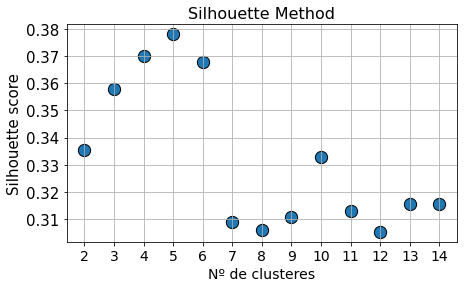

In [16]:
# Plotagem do método da Silhouette (Silhueta)
plt.figure(figsize=(7,4))
plt.title("Silhouette Method",fontsize=16)
plt.scatter(x=[i for i in range(2,max)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Nº de clusteres",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,max)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

### Utilizando o Scaler antes do Normalize

In [17]:
# Standardize data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df1), columns=columns)

In [18]:
# Normalizing
normalized_df = pd.DataFrame(normalize(scaled_df,axis=1), columns=columns)

In [19]:
# PCA
pca = PCA(2)
X_principal = pca.fit_transform(normalized_df)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

In [20]:
X_principal.head(2)

,P1,P2
0,-0.384607,-0.730559
1,0.281183,0.453901


In [21]:
GM = GaussianMixture(n_components=8)
GM.fit(X_principal)
X_principal['cl'] = GM.predict(X_principal)
X_principal.head()

,P1,P2,cl
0,-0.384607,-0.730559,4
1,0.281183,0.453901,5
2,-0.089414,0.096139,3
3,-0.525996,-0.472817,4
4,0.226420,0.386179,5


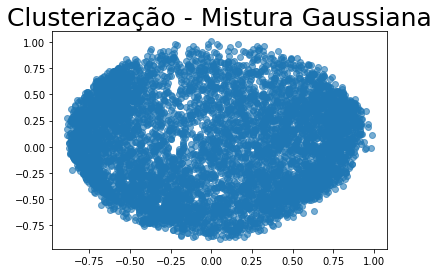

In [22]:
plt.title('Clusterização - Mistura Gaussiana',fontsize=25)
plt.scatter(data = X_principal,x = 'P1', y='P2' ,alpha=0.6, cmap='Blues')
plt.show()